# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [48]:
# Load the data file; make the datetime column the index
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])


In [49]:
# Print general information about 'df'
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [50]:
# Print a sample of the data for 'df'
df


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [51]:
# Resample the data by 1 hour
df = df.resample('1H').sum()
df


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [52]:
# Check if the dates and times are in chronological order
df.index.is_monotonic


True

<AxesSubplot:xlabel='datetime'>

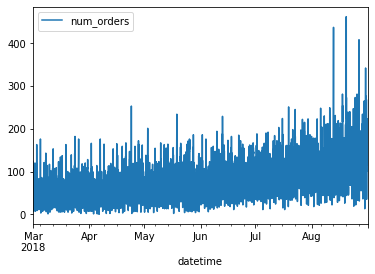

In [53]:
# Plot df to examine the trends/seasonality of the data
df.plot()


In [54]:
# Create a function to test the stationarity of the data
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(24).mean()
    roll_std = timeseries.rolling(24).std()
    
    original = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(roll_std, color = 'yellow', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)


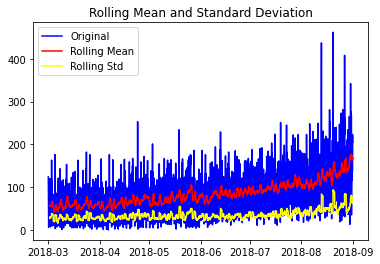

In [55]:
# Use the function with df to visualize whether or not the data is stationary
test_stationarity(df)


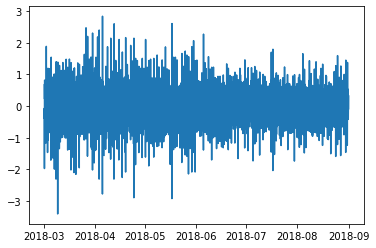

In [56]:
# Plot the log differences of df
df_log = np.log(df)
df_log_diff = df_log - df_log.shift()
plt.plot(df_log_diff)


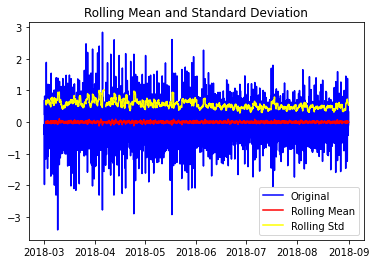

In [57]:
# Drop missing data from df_log_diff and use the 'test_stationarity' function to plot the graph
df_log_diff.dropna(inplace = True)
test_stationarity(df_log_diff)


Based on the two graphs testing the stationarity of the two plots, the plot using the log differences shows more consistent rolling mean and rolling standard deviations so 'df_log_diff' will be utilized in the training and predictions.

In [58]:
# Create a function to generate all the necessary features for training
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    data['num_orders'] = np.log(data['num_orders'])
    data['shift'] = data['num_orders'].shift()

    data['num_orders'] = data['num_orders'] - data['num_orders'].shift()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())
    
    return data


In [59]:
# Use the 'make_features' function to generate the data that will be used for training
logdata = make_features(df, 6, 6)
logdata


,num_orders,month,day,dayofweek,hour,shift,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-0.377630,3,1,3,1,4.820282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-0.179971,3,1,3,2,4.442651,-0.377630,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-0.073025,3,1,3,3,4.262680,-0.179971,-0.377630,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-0.428455,3,1,3,4,4.189655,-0.073025,-0.179971,-0.377630,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-0.420064,8,31,4,19,5.332719,-0.047179,0.096694,0.529614,-0.136759,-0.221639,0.199333,0.070011
2018-08-31 20:00:00,0.124298,8,31,4,20,4.912655,-0.420064,-0.047179,0.096694,0.529614,-0.136759,-0.221639,-0.033222
2018-08-31 21:00:00,0.031952,8,31,4,21,5.036953,0.124298,-0.420064,-0.047179,0.096694,0.529614,-0.136759,0.024434


## Training

In [60]:
# Split the data into a training and test set for the Linear Regression model
train, test = train_test_split(logdata, shuffle = False, test_size = 0.1)
train = train.replace([np.inf, -np.inf], np.nan).dropna()

target_train = train['num_orders']
target_test = test['num_orders']
shift_train = train['shift']
shift_test = test['shift']
features_train = train.drop(['num_orders','shift'], axis=1)
features_test = test.drop(['num_orders','shift'], axis=1)


In [61]:
# Train and test the Linear Regression model
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_train_pred = lr.predict(features_train)
lr_test_pred = lr.predict(features_test)

lr_train_pred_final = np.exp(lr_train_pred + shift_train)
lr_test_pred_final = np.exp(lr_test_pred + shift_test)
target_train_final = np.exp(target_train + shift_train)
target_test_final = np.exp(target_test + shift_test)

print("RMSE for the training set:", (mean_squared_error(lr_train_pred_final, target_train_final)) ** 0.5)
print("RMSE for the test set: ", (mean_squared_error(lr_test_pred_final, target_test_final)) ** 0.5)


RMSE for the training set: 32.73580767316167
RMSE for the test set:  54.20296828979486


In [62]:
# Split the data into train, valid, and test data for the remaining models
train, test = train_test_split(logdata, shuffle = False, test_size = 0.1)
train = train.replace([np.inf, -np.inf], np.nan).dropna()

target_test = test['num_orders']
shift_test = test['shift']
features_test = test.drop(['num_orders', 'shift'], axis = 1)

train, valid = train_test_split(train, shuffle = False, test_size = 0.2)

target_train = train['num_orders']
target_valid = valid['num_orders']
shift_train = train['shift']
shift_valid = valid['shift']
features_train = train.drop(['num_orders','shift'], axis = 1)
features_valid = valid.drop(['num_orders', 'shift'], axis = 1)


In [63]:
# Train and test the Decision Tree Regression model

# Create a for loop to tune the model's max depth and identify the depth that produces the lowest MAE value
best_score = float("inf")
best_depth = 0

for depth in range(1, 11):
    dt = DecisionTreeRegressor(random_state = 12345, max_depth = depth) # create a model with the given depth
    dt.fit(features_train, target_train) # train the model using the training set
    dt_pred_valid = dt.predict(features_valid) # get predicted values from the model based on validation set
    score = (mean_squared_error(target_valid, dt_pred_valid)) ** 0.5 # calculate the RMSE value based on the validation set
    if score < best_score: 
        best_score = score # save best RMSE value on validation set
        best_depth = depth # save depth corresponding to best RMSE value
        
print(f'RMSE of the best decision tree model on the validation set (max_depth = {best_depth}): {best_score}')


RMSE of the best decision tree model on the validation set (max_depth = 6): 0.3505731559728294


In [64]:
# Train and test the Random Forest Regression model

# Create a for loop to tune the model's number of estimators and identify the number that produces the lowest RMSE value
best_score = float("inf")
best_est = 0
for est in range(50, 71): # choose hyperparameter range
    rf = RandomForestRegressor(random_state = 12345, n_estimators = est) # set number of trees
    rf.fit(features_train, target_train) # train model on training set
    rf_pred_valid = rf.predict(features_valid) # get predicted values from the model based on validation set
    rf_pred_valid_final = np.exp(rf_pred_valid + shift_valid)
    target_valid_final = np.exp(target_valid + shift_valid)
    score = (mean_squared_error(target_valid_final, rf_pred_valid_final)) ** 0.5 # calculate RMSE value on validation set
    if score < best_score:
        best_score = score # save best accuracy score on validation set
        best_est = est # save number of estimators corresponding to best RMSE value

print(f'RMSE of the best random forest model on the validation set (n_estimators = {best_est}): {best_score}')


RMSE of the best random forest model on the validation set (n_estimators = 64): 32.40917347506196


## Testing

In [65]:
# Find the test set RMSE values for the Decision Tree model
dt = DecisionTreeRegressor(random_state = 12345, max_depth = best_depth) # create a model with the given depth
dt.fit(features_train.append(features_valid, ignore_index=True), target_train.append(target_valid, ignore_index=True))
dt_test_pred = dt.predict(features_test)

dt_test_pred_final = np.exp(dt_test_pred + shift_test)
target_test_final = np.exp(target_test + shift_test)

print("RMSE for the test set: ", mean_squared_error(dt_test_pred_final, target_test_final) ** 0.5)


RMSE for the test set:  45.153436829509914


In [66]:
# Find the test set RMSE values for the Random Forest model
rf = RandomForestRegressor(random_state = 12345, n_estimators = best_est) # set number of trees
rf.fit(features_train.append(features_valid, ignore_index=True), target_train.append(target_valid, ignore_index=True))
rf_test_pred = rf.predict(features_test)

rf_test_pred_final = np.exp(rf_test_pred + shift_test)

print("RMSE for the test set: ", mean_squared_error(rf_test_pred_final, target_test_final) ** 0.5)


RMSE for the test set:  40.35855963910251


Based on the data and analysis above, the following are the test set RMSEs that were calculated for the three models that were trained and tested:

1) Linear Regression: 54.20296828979486

2) Decision Tree: 45.153436829509914

3) Random Forest: 40.35855963910251


These results indicate that the **Random Forest Model** seems to best predict the amount of taxi orders for the next hour.

# Review checklist

- [x]  Jupyter Notebook is open
- [X]  The code is error-free
- [X]  The cells with the code have been arranged in order of execution
- [X]  The data has been downloaded and prepared
- [X]  The data has been analyzed
- [X]  The model has been trained and hyperparameters have been selected
- [X]  The models have been evaluated. Conclusion has been provided
- [X] *RMSE* for the test set is not more than 48